## Regression trees

Let's look at a simple example to get started.

Our goal is to **predict a baseball player's Salary** based on **Years** (number of years playing in the major leagues) and **Hits** (number of hits he made in the previous year). Here is the training data, represented visually (low salary is blue/green, high salary is red/yellow):

<img src="Images/salary_color.png" width="50%">


Below is a regression tree that has been fit to the data by a computer. (We will talk later about how the fitting algorithm actually works.) Note that  Salary is measured in thousands and has been log-transformed.

<img src="Images/salary_tree.png" width="50%">

Example predictions:

- Years=3, then predict 5.11 ($\$1000 \times e^{5.11} \approx \$166000$)
- Years=5 and Hits=100, then predict 6.00 ($\$1000 \times e^{6.00} \approx \$403000$)
- Years=8 and Hits=120, then predict 6.74 ($\$1000 \times e^{6.74} \approx \$846000$)

**How did we come up with the numbers at the bottom of the tree?** Each number is just the **mean Salary in the training data** of players who fit that criteria.

Here's the same diagram as before, split into the three regions:

<img src="Images/salary_regions.png" width="50%">

This diagram is essentially a combination of the two previous diagrams. In $R_1$, the mean log Salary was 5.11. In $R_2$, the mean log Salary was 6.00. In $R_3$, the mean log Salary was 6.74. Thus, those values are used to predict out-of-sample data.

Let's introduce some terminology:

<img src="Images/salary_tree_annotated.png" width="50%">

## Building a regression tree in scikit-learn

In [1]:
# read the training data into pandas and print it out
import pandas as pd
train = pd.read_csv('./Datasets/vehicles_train.csv')
train

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car


In [2]:
# encode car as 0 and truck as 1
train['type'] = train.type.map({'car':0, 'truck':1})

In [3]:
# create a list of the feature columns (every column except for the 0th column)
feature_cols = train.columns[1:]

In [4]:
# define X (features) and y (response)
X = train[feature_cols]
y = train.price

In [5]:
# import the relevant class, and instantiate the model (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)

In [6]:
# use 3-fold cross-validation to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score
import numpy as np
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4707.2505884845632

## Tuning a regression tree

Let's see if we can reduce the RMSE by tuning the **max_depth** parameter. One way to search for an optimal value would be to try different values, one by one:

In [7]:
# try max_depth=1
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4928.1374642038018

Or, we could write a loop to try a range of values:

In [8]:
# define a range of values
max_depth_range = range(1, 11)

# create an empty list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use cross-validation with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# print the results
RMSE_scores

[4928.1374642038018,
 4804.3767888427128,
 4592.1554255755254,
 4704.0052694797387,
 4707.2505884845632,
 4707.2505884845632,
 4707.2505884845632,
 4707.2505884845632,
 4707.2505884845632,
 4707.2505884845632]

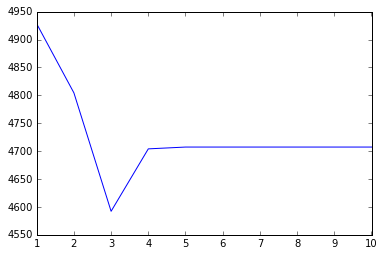

In [9]:
# plot the max_depth (x-axis) versus the RMSE (y-axis)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(max_depth_range, RMSE_scores)

In [10]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [11]:
# compute the "Gini importance" of each feature: the (normalized) total reduction of MSE brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,type,0.000000


## Creating a tree diagram

<img src="Images/tree_vehicles.png" width="90%">

## Predicting on test data

How good is scikit-learn's regression tree at predicting the price for test observations?

In [12]:
# read the test data
test = pd.read_csv('./Datasets/vehicles_test.csv')

# encode car as 0 and truck as 1
test['type'] = test.type.map({'car':0, 'truck':1})

# print the data
test

,price,year,miles,doors,type
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [13]:
# define X and y
X_test = test[feature_cols]
y_test = test.price

In [14]:
# make predictions on test data
y_pred = treereg.predict(X_test)
y_pred

array([ 22000.,  13500.,  13500.,   9250.,   9250.,   4000.,   2480.,
         2480.,   2480.,   2480.,   2480.,   5000.,   1550.,   1550.])

In [15]:
# calculate RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

364.29971961873059

# Linar Regression 

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd

df = pd.read_csv('./Datasets/housing.data', header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [18]:
from sklearn.linear_model import LinearRegression
X = df[['RM']].values
y = df['MEDV'].values
slr = LinearRegression()
slr.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return


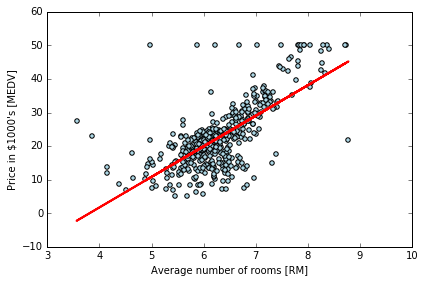

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()

In [21]:
X = df[['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'RM']].values
y = df['MEDV'].values

In [22]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [23]:
def Tree_regplot(X, y, model):
    X_temp=df['RM'].values
    plt.scatter(X_temp, y, c='lightblue')
    plt.scatter(X_temp, model.predict(X), color='red', linewidth=2)    
    return

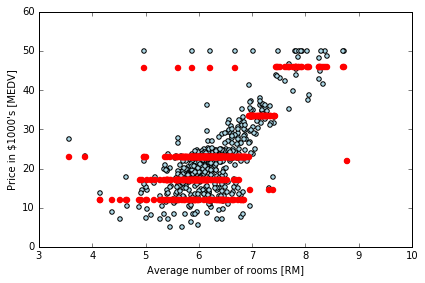

In [24]:
Tree_regplot(X, y, treereg)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()